# 采用文本挖掘的方法分析占领中环的新闻报道

““占领中环”，全称“让爱与和平占领中环”，简称“和平占中”或“占中”。“占中”于2013年3月27日发起，至2014年9月28日正式启动。近年来，“占领”运动在各国都有出现，已经成为一种街头政治的主要表现形式，是社会部分公众尤其是血气方刚的青年学生表达政治诉求的主要手段，表现出更强的对抗性。

####数据
我们使用从慧科数据库中提取的关于占中新闻报道进行文本挖掘，共计30642篇， 跨越两年时间（2013年2月到2015年2月），完整记录了占中的整个过程。

In [1]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys 
import numpy as np
from collections import defaultdict
import statsmodels.api as sm
from wordcloud import WordCloud
import jieba
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体  


In [2]:
# -*- coding: utf-8 -*-
with open("/Users/chengjun/百度云同步盘/Computational Communication/Data/占中数据20150328/occupycentralnews.txt") as f:
   news = f.readlines()
 
print news[5]


201310240030284 	星岛日报 	F11| 今日新闻通识| 今日香港  	建制派议员联署 批评与施明德商讨「占中」 	" 立法会建制派议员联署，要求「占领中环」发起人放弃「占中」行动，呼吁各界根据《基本法》、人大常委会解释及决定，理性务实讨论，推动政制发展。民建联主席谭耀宗点名批评真普联召集人郑宇硕及工党主席李卓人，到台湾与施明德会面讨论「占中」行动，是借助台独分子推动「占中」，令香港政治走向暴力对抗，挑战一国两制底线。　　详见A2版 课题研习 1.了解建制派议员联署与「占中」行动的最新发展。答：  2.以「本港政界人士与施明德讨论『占中』实属不当」为题进行辩论，陈述正反立场。答：  3.参考《基本法》、人大常委会解释及决定，你认为普选方案将是如何？　　各抒己见答： 参考资料 ．《基本法》  http://www.basiclaw.gov.hk/tc/index．占领中环──维基百科  http://zh.wikipedia.org/zh-hk/占领中环    "



In [3]:
# 定义一些常用的函数
def flushPrint(variable):
    if variable %10^2 == 0:
        sys.stdout.write('\r')
        sys.stdout.write('%s' % variable)
        sys.stdout.flush()
    
    
def top(data):
    for i in data:
        print i
        
def freq(data):
    dtable = defaultdict(int)
    for i in data:
        dtable[i] += 1
    return dtable

def sortdict(data):
    '''data is a dict, sorted by value'''
    return sorted(data.items(), lambda x, y: cmp(x[1], y[1]), reverse=True) 

def powerPlot(data):
    d = sorted(data, reverse = True )
    d_table = defaultdict(int)
    for k in d:
        d_table[k] += 1
    d_value = sorted(d_table)
    d_freq = [d_table[i] for i in d_value]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    #d_rank = ss.rankdata(d_value).astype(int)
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, 'ro')
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/5,max(d_prob)/5,
             'Beta = ' + str(round(beta,2)) +'\n' + 'R squared = ' + str(round(r2, 2)))
    plt.title('Size Distribution')
    plt.ylabel('Probability')
    plt.xlabel('Size')
    plt.show()    
    
def powerRankPlot(data):
    t = np.array(sorted(data,key=lambda x:-x))
    r = np.array(range(len(data))) +1
    x = np.log(r)
    y = np.log(t)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    plt.plot(r,t, "o",color='b',markersize=5)
    plt.plot(r, np.exp(constant+x*beta),"red")
    plt.text(min(r)+(max(r)-min(r))/10, min(t)+(max(t)-min(t))/2,  
             'Beta = ' + str(np.round(beta,2)) + '\n' + 'R squared = ' + str(np.round(r2, 2)))
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'Rank')
    plt.ylabel(r'Frequency')
    
def powerLawExponentialCutOffPlot(data):
    t = np.array(sorted(data,key=lambda x:-x))
    r = np.array(range(len(data))) +1
    r = r/float(np.max(r))
    y = np.log(r)
    x1 = np.log(t)
    x2 = t
    x = np.column_stack((x1,x2))
    x = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,x).fit()
    L,alpha,lambde = res.params
    plt.plot(t,r,".",color="SteelBlue",alpha=0.75,markersize=10)
    plt.plot(t, np.exp(L) * t ** alpha * np.exp(lambde * t),"r-")
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'value ')
    plt.ylabel(r'cumulative probability')
    #return [L,alpha,lambde]

def DGBDPlot(data):
    t=np.array(sorted(data,key=lambda x:-x))
    r=np.array(range(1,len(data)+1))   
    y = np.log(t)
    x1 = np.log(max(r)+1-r)
    x2 = np.log(r)
    x = np.column_stack((x1,x2))
    x = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,x).fit()
    [A,b,a] = res.params
    plt.plot(r,t,"o",color="b")
    plt.plot(r, np.exp(A)*(max(r)+1-r)**b*r**a,"r-")
    plt.yscale('log')
    plt.text(max(r)/2,max(t)/50,"b=" + str(round(b,2)) + ", a=" + str(round(a,2)))
    plt.xlabel(r'Rank ')
    plt.ylabel(r'Frequency')

def wordcloudplot(txt):
    wordcloud = WordCloud(font_path='/Users/chengjun/Library/Fonts/msyh.ttf').generate(txt)
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

def barplot(data, ylabel):
    datatable = freq(data)
    datatablesorted = sortdict(datatable) 
    dataname, datanum = np.array(datatablesorted).T
    datanum = datanum.astype(np.int)
    dataname =[m.decode('utf-8') for m in  dataname]

    fig = plt.figure(figsize=(18, 5),facecolor='white')
    ax = fig.add_subplot(111)
    ax.bar(range(len(datanum)), datanum)
    ax.set_xticks(range(len(datanum)))
    ax.set_xticklabels(dataname, rotation=90)
    plt.ylabel(ylabel)
    #plt.yscale('log')
    plt.show()

我们需要对文本格式的数据按行进行分割，并提取相应的变量。包括时间、媒体、作者、标题、内容五个部分。

In [4]:
n = 0
ids = []
media = []
info = []
title = []
body = []
for i in news:
    n += 1
    flushPrint(n)
    Id, Media, Info, Title, Body= i.split('\t')
    ids.append(Id)
    media.append(Media)
    info.append(Info)
    title.append(Title)
    body.append(Body)

len(ids)

30642

30643

In [5]:
print len(news), len(ids)

30643 30643


## 1. 时间分析

In [6]:
from datetime import *
dates = [ date(int(i[:4]), int(i[4:6]), int(i[6:8])) for i in ids]

In [7]:
datetable = freq(dates)

In [8]:
datetablesorted = sortdict(datetable)
for i, j in datetablesorted[1:20]:
    print i, j

2014-12-16 190
2013-07-02 137
2014-12-19 136
2014-07-09 129
2014-12-11 127
2014-12-15 126
2014-07-10 126
2014-12-18 121
2014-07-16 116
2014-05-23 115
2014-07-08 114
2014-12-13 113
2014-12-17 113
2013-07-09 112
2014-12-10 112
2014-07-18 112
2013-10-24 110
2014-12-31 110
2014-07-20 106


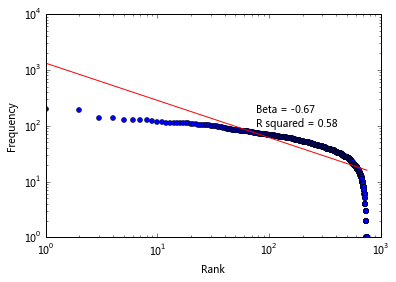

In [9]:

powerRankPlot(datetable.values())

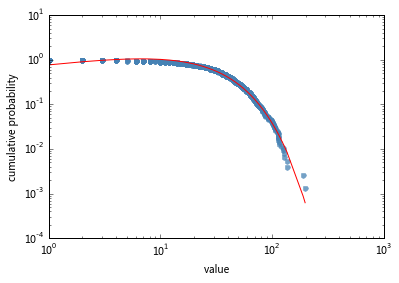

In [10]:
powerLawExponentialCutOffPlot(datetable.values())

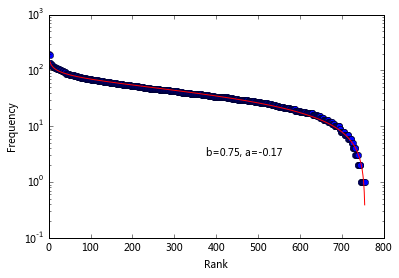

In [11]:
DGBDPlot(datetable.values())

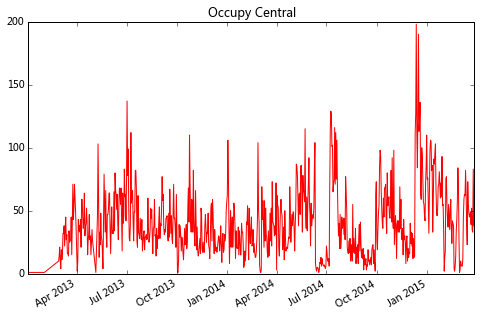

In [10]:
datelist = [(k,datetable[k]) for k in sorted(datetable.keys())] 

dates  = [q[0] for q in datelist]
values = [q[1] for q in datelist]

fig = plt.figure(figsize=(8, 5),facecolor='white')
ax = fig.add_subplot(111)
ax.plot_date(dates, values, 'r-')
fig.autofmt_xdate()
plt.title('Occupy Central')

###每个月的新闻数量及其标准差

In [116]:
day = [i[:8] for i in ids]
daytable = freq(day)

monthdict = defaultdict(list)
for k, v in daytable.iteritems():
    monthdict[str(k)[:6]].append(v) 

monthdata = defaultdict(list)   
for k, v in monthdict.iteritems():
    mean = np.mean(v)
    std = np.std(v)
    monthdata[k] = [mean, std]

month,mean,std = np.array(sorted([(month, monthdata[month][0], monthdata[month][1]) for month in monthdata])).T
month = [date( int(m[:4]), int(m[4:6]), 01) for m in month]
mean = mean.astype(np.float)
std = std.astype(np.float)

In [232]:
month

array([datetime.date(2013, 1, 1), datetime.date(2013, 2, 1),
       datetime.date(2013, 3, 1), datetime.date(2013, 4, 1),
       datetime.date(2013, 5, 1), datetime.date(2013, 6, 1),
       datetime.date(2013, 7, 1), datetime.date(2013, 8, 1),
       datetime.date(2013, 9, 1), datetime.date(2013, 10, 1),
       datetime.date(2013, 11, 1), datetime.date(2013, 12, 1),
       datetime.date(2014, 1, 1), datetime.date(2014, 2, 1),
       datetime.date(2014, 3, 1), datetime.date(2014, 4, 1),
       datetime.date(2014, 5, 1), datetime.date(2014, 6, 1),
       datetime.date(2014, 7, 1), datetime.date(2014, 8, 1),
       datetime.date(2014, 9, 1), datetime.date(2014, 10, 1),
       datetime.date(2014, 11, 1), datetime.date(2014, 12, 1),
       datetime.date(2015, 1, 1), datetime.date(2015, 2, 1),
       datetime.date(2015, 3, 1)], dtype=object)

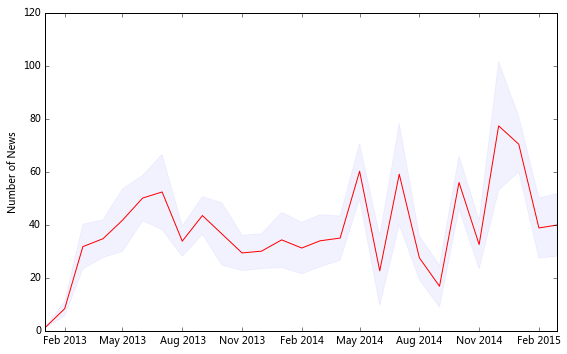

In [12]:
fig = plt.figure(figsize=(8, 5),facecolor='white')
cmap = cm.get_cmap('Accent_r', len(month))
plt.plot(month,mean,marker='',linestyle='-',color='r',label=str(month))
plt.fill_between(month, mean-std/2, mean+std/2,color='b',alpha=0.05)
plt.ylabel('Number of News')
#plt.title(u'占领中环相关新闻数量')
plt.tight_layout()
plt.show()

In [117]:
mean

array([  1.        ,   8.33333333,  31.74193548,  34.72413793,
        41.70833333,  50.06666667,  52.35483871,  33.80645161,
        43.46666667,  36.53333333,  29.36666667,  30.03225806,
        34.29032258,  31.21428571,  33.93548387,  34.96666667,
        60.16129032,  22.62068966,  59.06451613,  27.51612903,
        16.8       ,  55.93548387,  32.53333333,  77.29032258,
        70.35483871,  38.78571429,  39.89285714])

由上图可以知道，在2013年上半年占中报道经历了舆论形成的阶段，在2013年7月到达第一次巅峰，之后从2013年11月到2014年5月七个月时间里保持了相对稳定的舆论热度。之后在震荡当中保持稳定。

#### 排名前10的报纸关于占中的报道随时间演化

In [300]:
mediatable = freq(media)
mediatablesorted = sortdict(mediatable) 
top10 = [m[0] for m in mediatablesorted[0:10]]
day = [i[:8] for i in ids]


top10dict = defaultdict(list)

for t in top10:
    dayt =  [day[i] for i,x in enumerate(media) if x == t]
    daytable = freq(dayt)
    monthdict = defaultdict(list)
    for k, v in daytable.iteritems():
        monthdict[str(k)[:6]].append(v) 

    monthdata = defaultdict(list)   
    for k, v in monthdict.iteritems():
        mean = np.mean(v)
        std = np.std(v)
        monthdata[k] = [mean, std]

    month,mean,std = np.array(sorted([(month, monthdata[month][0], monthdata[month][1]) for month in monthdata])).T
    month = [date( int(m[:4]), int(m[4:6]), 01) for m in month]
    mean = mean.astype(np.float)
    std = std.astype(np.float)
    top10dict[t].append([month, mean, std])

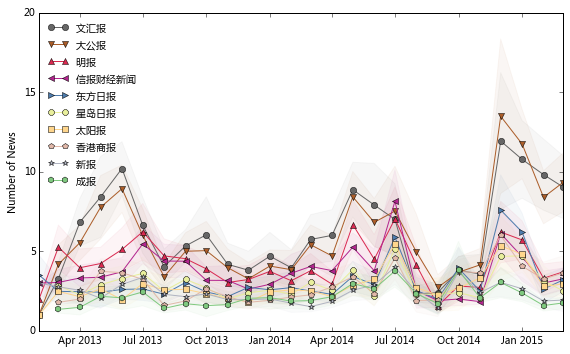

In [302]:
fig = plt.figure(figsize=(8, 5),facecolor='white')
cmap = cm.get_cmap('Accent_r', len(top10dict))
filled_markers = [u'o', u'v', u'^', u'<', u'>', u'8', u's', u'p', u'*', u'h', u'H', u'D', u'd']

n = 0
for k in top10:
    month, mean, std = top10dict[k][0]
    plt.plot(month,mean,linestyle='-',color=cmap(n), marker = filled_markers[n] )
    plt.fill_between(month, mean-std/2, mean+std/2,color=cmap(n),alpha=0.05)
    n += 1
labels = [m.decode('utf-8') for m in top10]
lg=plt.legend(labels = labels, loc=2, fontsize=10)
lg.draw_frame(False)
plt.ylabel('Number of News')
#plt.title(u'占领中环相关新闻数量')
plt.tight_layout()
plt.show()

这张图详细展示了24个月份里，占中报道排名前十的媒体的新闻报道情况。文汇报、大公报、明报等报道最多，前十名的报纸报道总量占整个占中的新闻报道的72%，主导了占中报道的总体趋势。而苹果日报等民粹主义报纸则在占中报道的数量上相对保守。

In [18]:
print body[1]

" 正在北京访问的特首梁振英，昨午偕同政制及内地事务局局长谭志源，与全国人大常委会委员长兼港澳协调小组组长张德江会面。梁振英指自己向张德江介绍了「政改谘询专责小组」工作。他引述张德江与他会面时表明，中央真心希望香港可以按照《基本法》及全国人大常委会的相关解释及决定，落实二○一七年普选行政长官。 本报记者 梁振英昨日在没有知会传媒情况下，与张德江会面。他稍后会见传媒时才表示，已跟张德江会见完毕。他在会上介绍了由政务司司长林郑月娥及谭志源也有份参与的政改谘询专责小组的工作，包括争取在年底发表谘询文件，正式启动二○一七年行政长官及二○一六年立法会产生办法的公众谘询，而委员长在听了他报告后，明确表示中央真心希望香港可成功落实普选。 没有谈到「占中」 梁振英称与中央会面期间没有谈到「占中」。被问到张德江或他早前会见的港澳办主任王光亚，有否对普选提出看法，如提名委员会或公民提名。梁振英表示政府连谘询文件也未发出，双方没有谈到具体内容，而张德江给特区政府的具体指引，就是根据《基本法》和人大常委的有关决定办事。 梁振英又感谢中央大力支持特区政府跟进菲律宾马尼拉人质事件，包括与菲律宾总统府等有关方面的联系工作。他希望中央继续支持特区政府，透过与菲律宾高层官员会面以解决问题。 商巩固金融中心地位 梁振英也有提到金融发展问题。他介绍了香港作为离岸人民币业务中心的重要性，对国家货币改革、作为国家及国际金融中心发展的重要性。他指很多地区，如新加坡和伦敦都争取人民币业务，香港不能落后于形势，希望中央给予更大支持。特区政府会继续采取措施，巩固和提升香港作为国际离岸人民币贸易结算、融资和资产管理中心的地位。 至于与中央官员会面时有否谈到电视发牌引起风波的问题。梁强调电视发牌问题，完全是特区政府自治范围内的事，会面时没有提到。 梁振英昨午与港澳办主任王光亚会面，随行的包括特首办主任邱腾华、财经事务及库务局局长陈家强，以及政制及内地事务局局长谭志源。梁指他与王光亚及财金部委开会时，也有深入讨论香港如何配合国家「十三．五」规划发展，双方集中谈到离岸人民币业务结算、推出创新和多元化人民币投资产品，及内地个人以「合格境内个人投资者」方式到外地进行投资，即QDII2的问题。    "



In [24]:
def getWordList(w):
    wordlist=[]
    for i in body:
        if w in i.decode('utf8'):
            wordlist.append(1)
        else:
            wordlist.append(0)
    return wordlist



# 词频统计

In [65]:
from collections import Counter, defaultdict

wordfreqs = defaultdict(int)
txt = r' '.join(body)
seg_alist = jieba.cut(txt, cut_all=False)
for i in seg_alist:
    wordfreqs[i] +=1
wordfreqs = sorted(wordfreqs.items(), key = lambda x:-x[1]) 

In [77]:
def get_wordfreq(ids, word):
    # get wordlist first
    wordlist=[]
    for i in body:
        if word in i.decode('utf8'):
            wordlist.append(1)
        else:
            wordlist.append(0)
    # get monthly data
    month = [i[:6] for i in ids]
    monthdict = defaultdict(int)
    for i, j in enumerate(month):
        monthdict[j]+= wordlist[i]  
    month = monthdict.keys()
    month = [date( int(m[:4]), int(m[4:6]), 01) for m in month]
    wordfreq = monthdict.values()
    month, wordfreq = np.array(sorted(zip(month, wordfreq))).T
    return month, wordfreq

print top500[100], get_wordfreq(ids, top500[100])

影响 (array([datetime.date(2013, 1, 1), datetime.date(2013, 2, 1),
       datetime.date(2013, 3, 1), datetime.date(2013, 4, 1),
       datetime.date(2013, 5, 1), datetime.date(2013, 6, 1),
       datetime.date(2013, 7, 1), datetime.date(2013, 8, 1),
       datetime.date(2013, 9, 1), datetime.date(2013, 10, 1),
       datetime.date(2013, 11, 1), datetime.date(2013, 12, 1),
       datetime.date(2014, 1, 1), datetime.date(2014, 2, 1),
       datetime.date(2014, 3, 1), datetime.date(2014, 4, 1),
       datetime.date(2014, 5, 1), datetime.date(2014, 6, 1),
       datetime.date(2014, 7, 1), datetime.date(2014, 8, 1),
       datetime.date(2014, 9, 1), datetime.date(2014, 10, 1),
       datetime.date(2014, 11, 1), datetime.date(2014, 12, 1),
       datetime.date(2015, 1, 1), datetime.date(2015, 2, 1),
       datetime.date(2015, 3, 1)], dtype=object), array([1, 5, 270, 360, 419, 631, 473, 287, 343, 293, 257, 204, 235, 260,
       292, 306, 644, 215, 585, 251, 202, 833, 418, 931, 731, 424, 380], d

In [118]:
month = get_wordfreq(ids, top500[100])[0]


In [127]:
len(month)

27

In [126]:
[m.strftime("%Y-%m-%d")  for m in month]



['2013-01-01',
 '2013-02-01',
 '2013-03-01',
 '2013-04-01',
 '2013-05-01',
 '2013-06-01',
 '2013-07-01',
 '2013-08-01',
 '2013-09-01',
 '2013-10-01',
 '2013-11-01',
 '2013-12-01',
 '2014-01-01',
 '2014-02-01',
 '2014-03-01',
 '2014-04-01',
 '2014-05-01',
 '2014-06-01',
 '2014-07-01',
 '2014-08-01',
 '2014-09-01',
 '2014-10-01',
 '2014-11-01',
 '2014-12-01',
 '2015-01-01',
 '2015-02-01',
 '2015-03-01']

In [351]:
topwords = [u'香港',u'普选',u'政改',u'政治',u'占领',u'中央',u'特首',
            u'反对派',u'中环',u'戴耀廷',u'民主',u'泛民',u'法制',u'港独',u'违法']

wordfreq_dict = {}
for i in topwords:
    tf = get_wordfreq(ids, i)[1]
    wordfreq_dict[i] = tf
    
    

In [78]:
top500 = [i[0] for i in wordfreqs[:500]]     
wordfreq_dict = {}
for i in top500:
    tf = get_wordfreq(ids, i)[1]
    wordfreq_dict[i] = tf

In [352]:
#','.join(wordfreq_dict.values()[10])
for i in wordfreq_dict:
    j = wordfreq_dict[i]
    j = ','.join([str(ii) for ii in j])
    print i+','+j +'\n'

戴耀廷,0,9,340,280,265,404,455,249,218,225,155,261,142,87,139,168,300,104,125,41,21,29,24,217,307,121,117

普选,0,15,733,591,462,667,855,437,697,598,427,547,582,424,585,560,900,251,736,384,170,220,111,709,678,315,288

泛民,0,12,345,236,130,153,320,171,228,195,196,178,230,222,252,284,527,130,389,178,60,37,27,322,410,158,169

法制,0,0,30,16,36,64,32,29,34,24,38,22,27,9,37,39,43,16,31,16,3,31,19,58,42,18,28

占领,0,24,917,882,833,1182,1120,640,764,662,496,527,554,440,606,598,880,356,593,220,118,528,259,1391,1040,389,324

香港,0,14,803,778,757,1173,1173,773,1012,872,695,674,749,631,820,838,1291,470,1270,599,367,1277,687,1806,1681,849,876

政改,0,13,409,321,219,395,517,303,471,359,330,525,522,411,548,576,922,230,692,273,176,180,41,611,696,306,358

反对派,0,4,251,334,326,516,338,226,279,300,232,217,250,190,277,267,434,138,307,100,56,56,32,402,457,263,218

中环,0,24,918,889,846,1219,1158,658,811,669,513,554,602,494,574,554,903,360,627,240,138,353,98,314,214,95,96

中央,1,12,590,475,351,500,564,264,576,475,402,401,

In [115]:
with open("/Users/chengjun/百度云同步盘/Computational Communication/Data/占中数据20150328/occupycentral_wordfreq.txt", 'a') as f:
    for i in wordfreq_dict:
        j = wordfreq_dict[i]
        j = ','.join([str(ii) for ii in j])
        f.write( i.encode('utf-8')+','+j +'\n')

In [15]:
from datetime import *

def getdata(ids, wordlist):
    month = [i[:6] for i in ids]
    monthdict = defaultdict(int)
    for i, j in enumerate(month):
        monthdict[j]+= wordlist[i]  
    month = monthdict.keys()
    month = [date( int(m[:4]), int(m[4:6]), 01) for m in month]
    wordfreq = monthdict.values()
    month, wordfreq = np.array(sorted(zip(month, wordfreq))).T
    return month, wordfreq

wordlist = getWordList(u'反占中')
wordlist1 = [1 for i in ids]
wordlist2 = getWordList(u'台独')
wordlist3 = getWordList(u'美国')
wordlist4 = getWordList(u'普选')
wordlist5 = getWordList(u'政改')
wordlist6 = getWordList(u'爱港')
wordlist7 = getWordList(u'爱国')
wordlist8 = getWordList(u'港独')
wordlist9 = getWordList(u'台独')
wordlist10 = getWordList(u'真普选')

month, wordfreq = getdata(ids, wordlist)
month1, wordfreq1 = getdata(ids, wordlist1)
month2, wordfreq2 = getdata(ids, wordlist2)
month3, wordfreq3 = getdata(ids, wordlist3)
month4, wordfreq4 = getdata(ids, wordlist4)
month5, wordfreq5 = getdata(ids, wordlist5)
month6, wordfreq6 = getdata(ids, wordlist6)
month7, wordfreq7 = getdata(ids, wordlist7)
month8, wordfreq8 = getdata(ids, wordlist8)
month9, wordfreq9 = getdata(ids, wordlist9)
month10, wordfreq10 = getdata(ids, wordlist10)

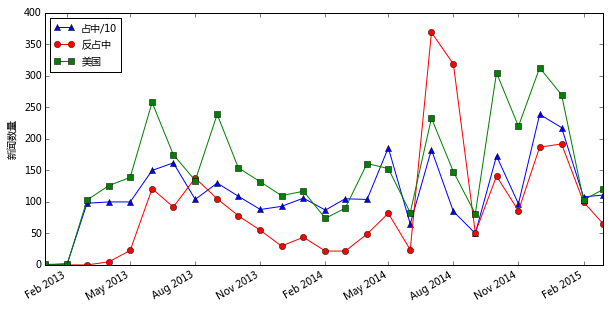

In [93]:
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(111)
ax.plot_date(month1, wordfreq1/10, 'b-^')
ax.plot_date(month, wordfreq, 'r-o')
#ax.plot_date(month2, wordfreq2, 'g-s')
ax.plot_date(month3, wordfreq3, 'g-s')

plt.ylabel(u'新闻数量')
labels = [u'占中/10', u'反占中',
          #u'台独', 
          u'美国']
lg=plt.legend(labels = labels, loc=2, fontsize=10)
fig.autofmt_xdate()

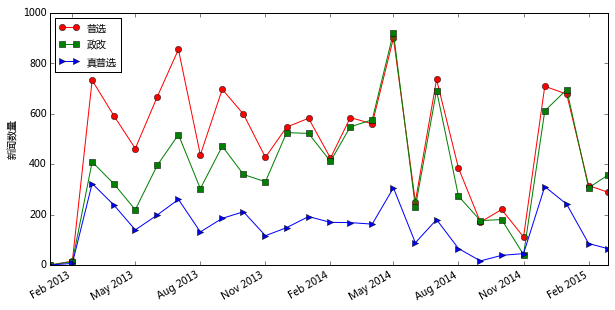

In [128]:
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(111)
ax.plot_date(month4, wordfreq4, 'r-o')
ax.plot_date(month5, wordfreq5, 'g-s')
ax.plot_date(month10, wordfreq10, 'b->')

plt.ylabel(u'新闻数量')
labels = [u'普选', u'政改', u'真普选']
lg=plt.legend(labels = labels, loc=2, fontsize=10)
fig.autofmt_xdate()

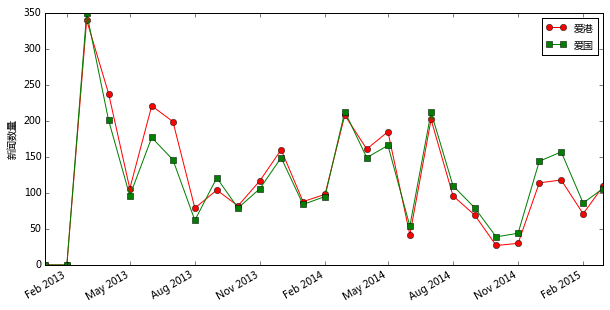

In [98]:
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(111)
ax.plot_date(month6, wordfreq6, 'r-o')
ax.plot_date(month7, wordfreq7, 'g-s')
plt.ylabel(u'新闻数量')
labels = [u'爱港', u'爱国']
lg=plt.legend(labels = labels, loc=1, fontsize=10)
fig.autofmt_xdate()

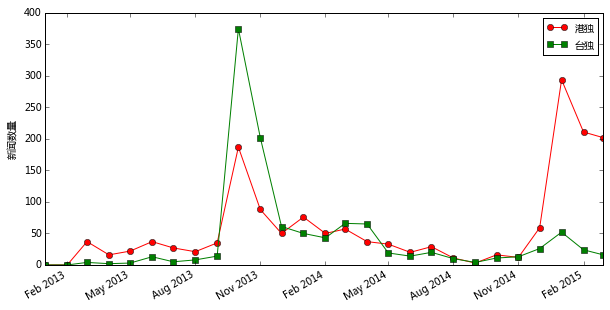

In [100]:
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(111)
ax.plot_date(month8, wordfreq8, 'r-o')
ax.plot_date(month9, wordfreq9, 'g-s')
plt.ylabel(u'新闻数量')
labels = [u'港独', u'台独']
lg=plt.legend(labels = labels, loc=1, fontsize=10)
fig.autofmt_xdate()

## 2. 作者分析

In [130]:
author = []

for i in info:
    try:
        author.append(i.split('By')[1])
    except:
        author.append('')
        pass

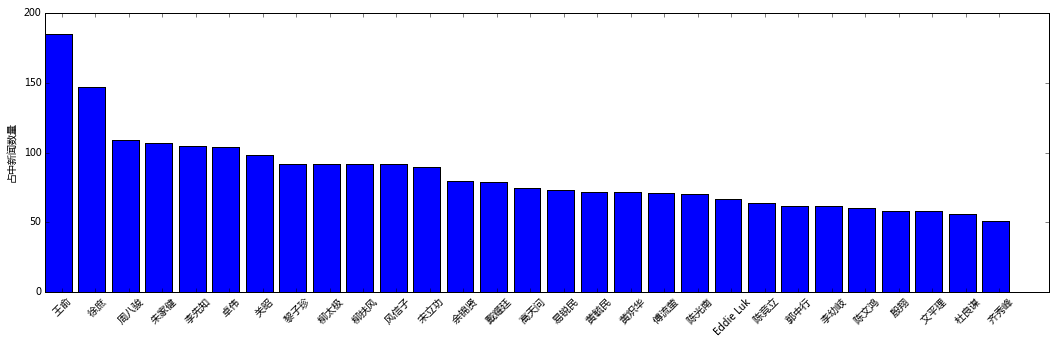

In [131]:
def barplot2(data, ylabel):
    datatable = freq(data)
    datatablesorted = sortdict(datatable) 
    dataname, datanum = np.array(datatablesorted).T
    datanum = datanum.astype(np.int)
    dataname =[m.decode('utf-8') for m in  dataname]
    
    datanum = datanum[1:30]
    dataname = dataname[1:30]
    fig = plt.figure(figsize=(18, 5),facecolor='white')
    ax = fig.add_subplot(111)
    ax.bar(range(len(datanum)), datanum)
    ax.set_xticks([ i+0.5 for i in range(len(datanum))])
    ax.set_xticklabels(dataname, rotation= 45)
    plt.ylabel(ylabel)
    #plt.yscale('log')
    plt.show()
barplot2(author, u'占中新闻数量')

In [132]:
authortable = freq(author)   
authortablesorted = sortdict(authortable)
for i, j in authortablesorted[1:20]:
    print i, j

 王俞   185
 徐庶   147
 周八骏   109
 朱家健   107
 李先知   105
 卓伟   104
 关昭   98
 黎子珍   92
 柳太极   92
 柳扶风   92
 风信子   92
 宋立功   90
 余锦贤   80
 戴耀廷   79
 高天问   75
 易锐民   73
 黄毓民   72
 黄炽华   72
 傅流萤   71


值得注意的是作为占中三子之一的戴耀廷在这个过程当中持续发表了79篇署名相关新闻报道。

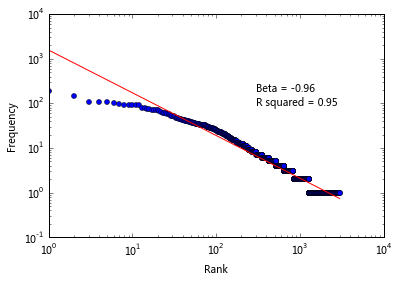

In [205]:
authortablesortedreal = [] 
for i in authortablesorted[1:]:
    authortablesortedreal.append(i[1])
powerRankPlot(authortablesortedreal)

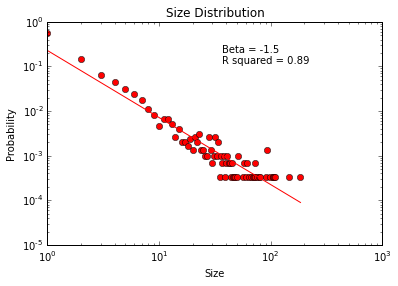

In [14]:
powerPlot(authortablesortedreal)

[-0.36181199704668776, -0.86852726572500272, -0.015597906353085894]

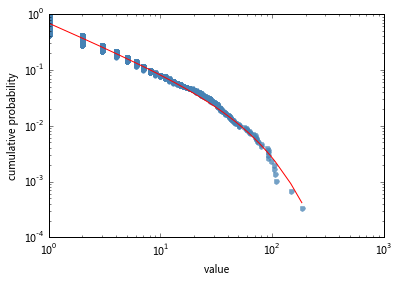

In [206]:
powerLawExponentialCutOffPlot(authortablesortedreal)

## 3. 语言识别

In [571]:
from langdetect import detect
def langdect(txtlist):
    lang = []
    for n, x in enumerate(txtlist):
        if n % 10**2 == 0:
            flushPrint(n)
        try:
            a = detect(x)
            lang.append('en')
        except:
            lang.append('cn')
            pass
    return lang

In [565]:
lang = langdect(title)

30600

In [575]:
enindex = [i for i, x in enumerate(lang) if x == 'en']
entitles = [title[i] for i in enindex]
cnindex = [i for i, x in enumerate(lang) if x == 'cn']
cntitles = [title[i] for i in cnindex]

##4. 标题分析

In [574]:
top(title[0:10])


硬拉无助解政改之结 
张德江：真心盼港落实普选 梁振英在京汇报政改 
建制派声明警告反对派 悬崖勒马停止勾结「台独」 
朱耀明：不认为被台独人士利用 
傅振中论反占中观众够包容 
建制派议员联署 批评与施明德商讨「占中」 
戴耀廷：占中不会搞「港独」 与施明德划清界线 
台独派撑「占中」 周融质疑动机 
律师会长突「愤怒」批占中 
用词挑拨夸大无稽 


In [576]:
top(entitles[0:10])

Pan-democrats' Taiwan visit 
HK needs democratic culture 
Mathieson confirmed as new head of HKU 
Occupy group's flirt with Taipei slammed 
Pro-democracy leaders to share ideas in Taiwan 
Beijing sincere about universal suffrage in 2017: C.Y. 
Universal suffrage at the crossroads 
Breaking the law is the whole point 
BRIEFS 
Tai has betrayed democratic principles by advocating bloodshed 


In [578]:
index = [i for i,x in enumerate(media) if x == r'英文虎报 ']
tigertitles = [title[i] for i in index]


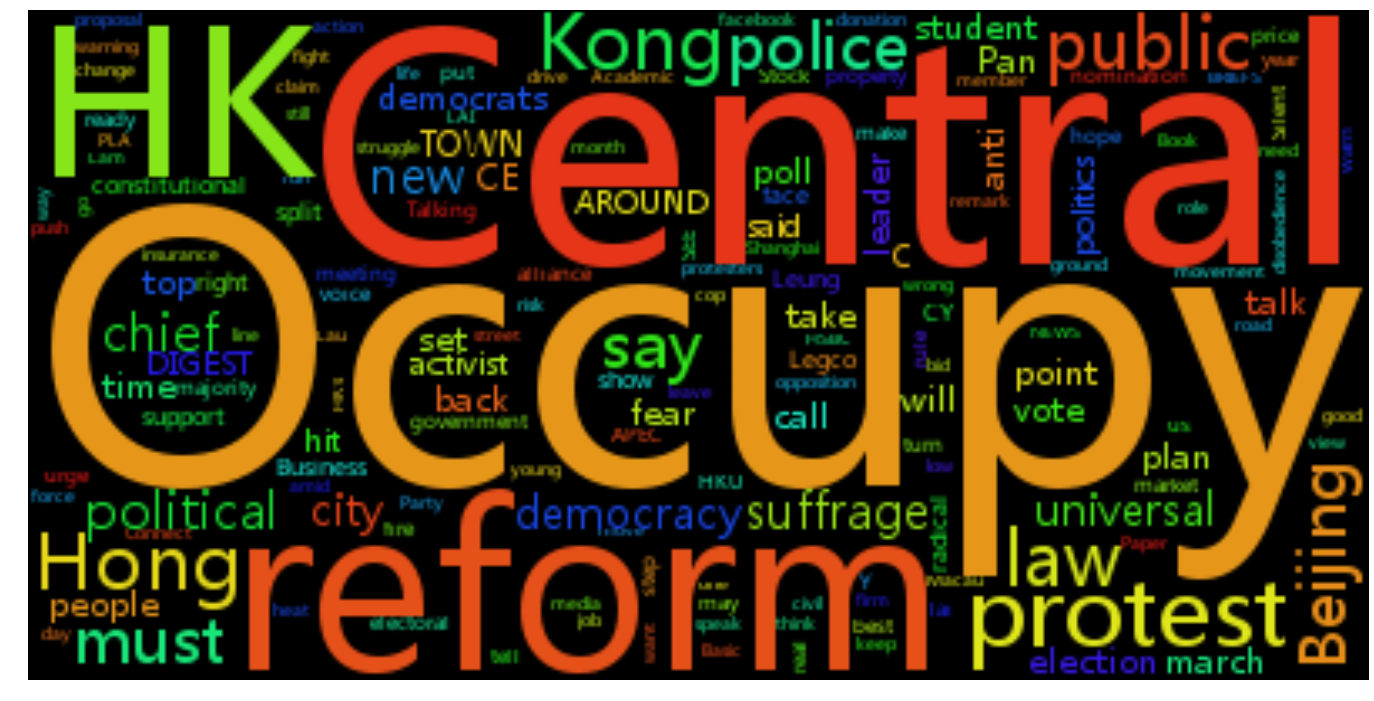

In [577]:
entitletxt = ''.join(entitles)
wordcloudplot(entitletxt)

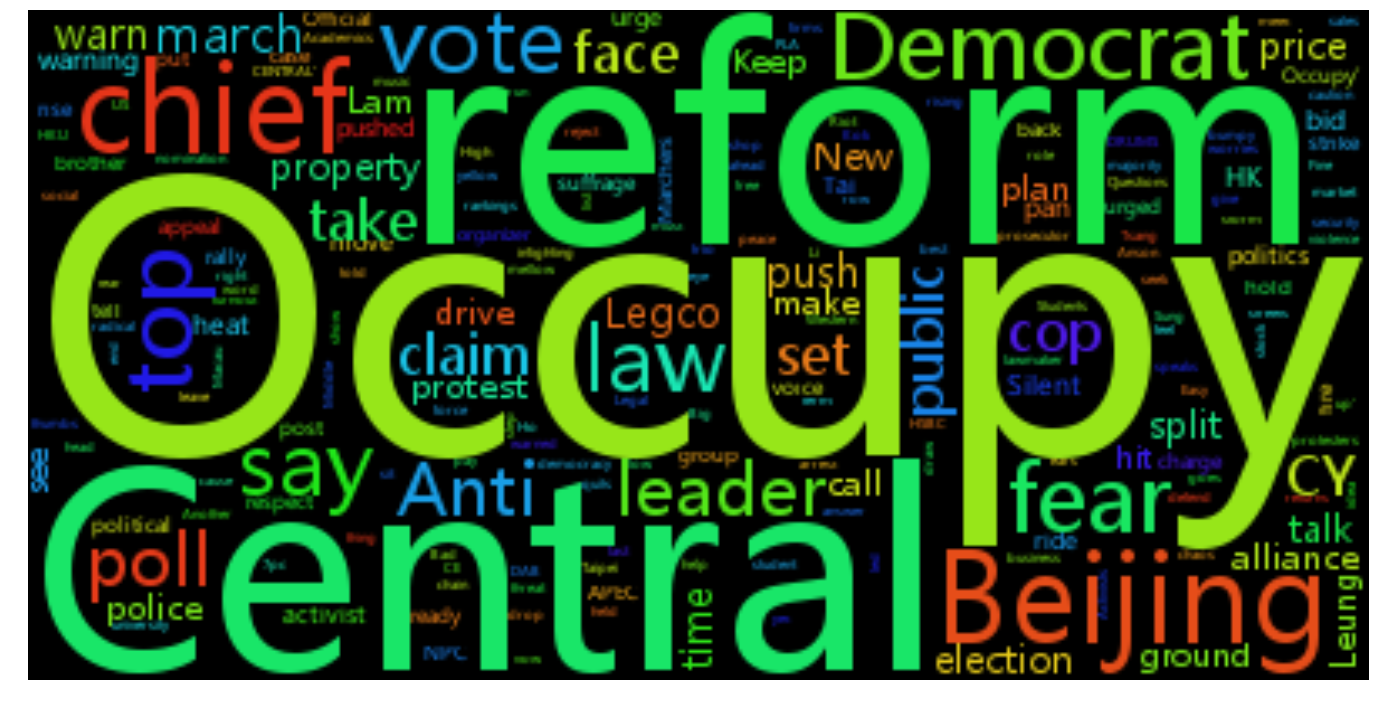

In [579]:
# Read the whole text.
tigertxt = ''.join(tigertitles)
wordcloudplot(tigertxt)

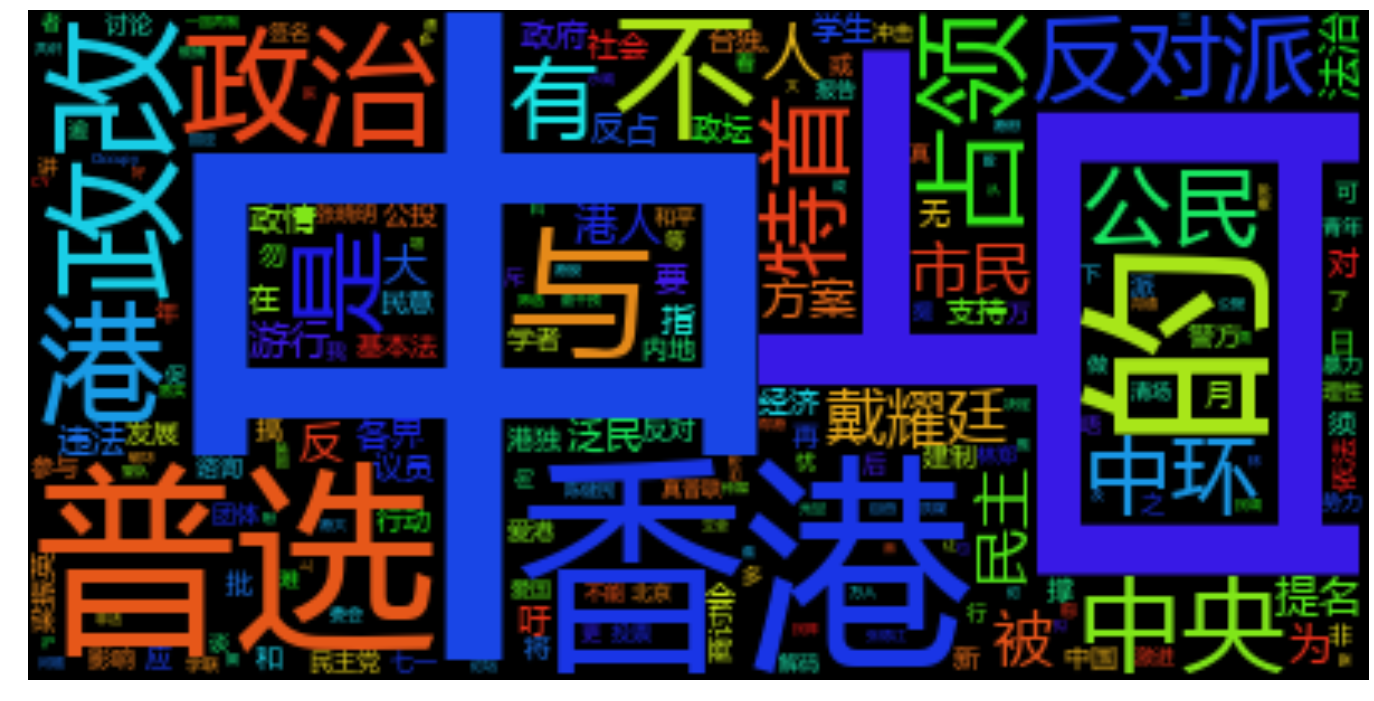

In [580]:
# jieba.suggest_freq('占中', True)
jieba.add_word('占中', freq=100, tag=None) 
jieba.add_word('中港', freq=100, tag=None) 
txt = r' '.join(cntitles)
seg_list = jieba.cut(txt, cut_all=False)
txt = r' '.join(seg_list)
wordcloudplot(txt) 

In [19]:
import jieba.analyse
# TextRank: Bringing Order into Texts
keywords = jieba.analyse.textrank(txt, topK=20, withWeight=False) 
top(keywords)

占
香港
普选
有
政治
人
中央
是
反对派
占领
会
特首
中环
公民
泛民
民主
要
市民
提名
无


## 5. 媒体基本情况

In [179]:
mediatable = freq(media)
mediatablesorted = sortdict(mediatable) 
for i, j in mediatablesorted:
    print i,j

文汇报  4091
大公报  3978
明报  2773
信报财经新闻  1942
东方日报  1905
星岛日报  1775
太阳报  1674
香港商报  1593
新报  1276
成报  1147
香港经济日报  920
南华早报  852
am730  687
头条日报  549
都市日报  542
晴报  454
英文虎报  373
中国日报香港版  362
联合早报 (新加坡)  224
亚洲周刊  189
明报加西版(温哥华)  186
联合报  181
自由时报  176
明报加东版(多伦多)  166
东周刊  166
南洋商报  165
经济日报（台湾）  108
星洲日报(马来西亚)  106
香港政府新闻- 中文版  104
中国时报  95
智富杂志  86
工商时报  84
人民日报  77
新闻晨报  68
中国报  62
经济一周  59
公教报  59
慧科专讯  48
投资理财  47
南方都市报(全国版）  46
新华每日电讯  45
信报财经月刊  40
广州日报  40
解放日报  38
羊城晚报(全国版)  38
新民晚报  38
北京青年报  36
新京报  35
经济日报  35
东方新地  34
深圳晚报  34
北京晨报  33
浙江日报  33
文汇报(上海)  31
明报 - 教得乐  29
齐鲁晚报  29
香港政府新闻 - 英文版  29
开放杂志  27
海峡时报 (新加坡)  26
法制日报（电子报）  25
钱江晚报  25
湖北日报  25
新假期  25
茶杯杂志  24
潇湘晨报  24
U magazine  22
新明日报  22
楚天都市报  20
青岛日报  20
置业家居  19
新华日报  18
江南都市报  17
上海证券报  15
e-zone  15
Milk  15
重庆日报  14
东Touch  14
今晚报  14
21世纪经济报道  14
重庆晨报  13
福建日报  13
现代快报  13
中国经营报  13
我报 (中文版)  12
证券日报  11
经济观察报  10
JET  10
明报周刊  9
光明日报(马来西亚)  8
南方日报(全国版）  8
广西日报  7
联合晚报(新加坡)  7
金融时报  7
国际金融报  6
慧科股价快讯  6
中国青年报 

In [311]:
mediatop10 = [j for i, j in mediatablesorted[:10]]

np.float(np.sum(mediatop10))/len(ids)


0.7229709884802402

In [306]:
len(mediatablesorted)

114

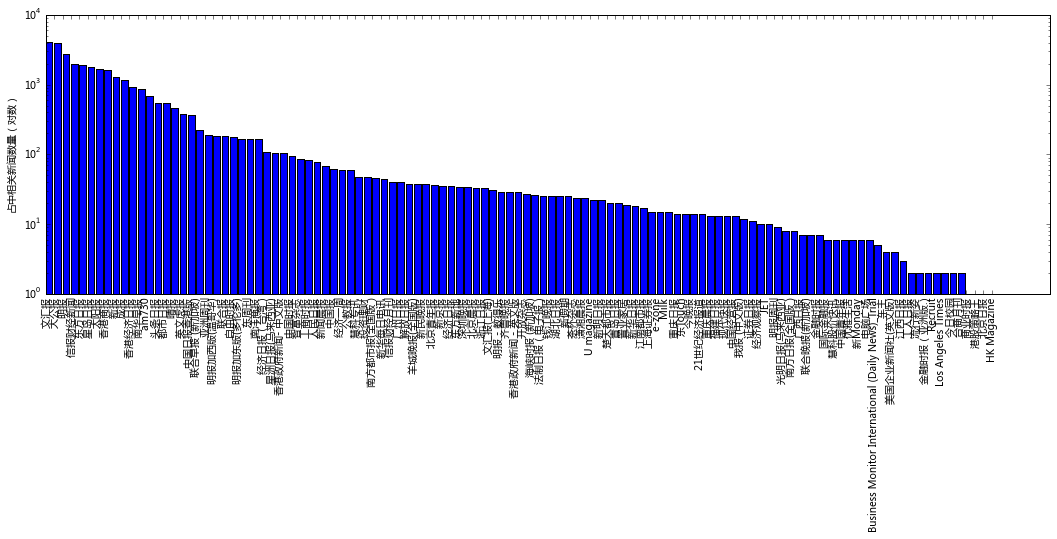

In [209]:
barplot(media, u'占中相关新闻数量（对数）')

新闻来源包括大陆和香港，和少数外部媒体。对比大陆和香港媒体的新闻报道进行分析很有必要。科学研究开始于分组实验。只有分组，才能分析差异性。

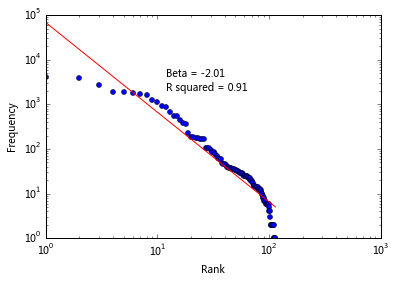

In [197]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)  
powerRankPlot(newsnum)

显然，直接使用powerlaw拟合或者简单地变形其拟合结果并不能很好，解决平头和降尾的方式是引入非线性，例如使用指数降尾或者dgbd来拟合。

[0.33267970051302465, -0.32795629294522377, -0.00049602306513002654]

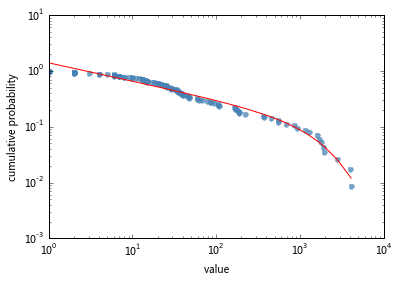

In [198]:
powerLawExponentialCutOffPlot(newsnum)

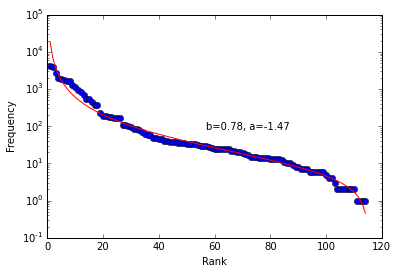

In [24]:
DGBDPlot(mediatable.values())

## 6. 内容分析

In [25]:
top(body[0:1])

" 2017年行政长官普选方案尚未正式展开谘询，社会已迫不及待，掀起议论热潮，其中各方观点不乏尖锐对立，难以调和。尤其是「全民提名联署约章」的恶意捆绑，「占领中环」的肆意威逼，美国夏千福、英国施维尔的公然外力介入，更令剑拔弩张，气氛严峻，叫人对如期实现普选不敢抱太大期望。     立法会通过门槛不低     其实，要顺利完成政改，解开政制发展之结，走向众所期待的普选目标，最需要的就是尊重基本法和人大常委会有关决定的共识，需要的是大和解大妥协，需要的是互信互尊的宽松环境；否则，各方斗个不休，僵持不下，企硬不让，强力背向而拉的话，只会令这个结更紧，甚至变为解不开的死结。这也是法定政改程序和机制的特点所决定的，政改不是拳击式的零和游戏，而是共识协力、谋求多赢的联合攻关。     中央政府支持香港实现普选的立场，已体现为基本法的规定和2007年人大常委会有关决定给出的时间表，以法律形式固化了承诺，诚意不容置疑。而按2004年4月6日人大释法确立的「政改五部曲」，香港要成功进行政改，除了政改方案具有可操作性，不是「中看不中用」之外，必须在行政长官(特区政府)、全国人大常委会、立法会全体议员的三分之二多数之间，达成共识方案，这是必要且充分的前提条件。也就是说，要打开政改之锁，取出普选重宝，必须配齐三把钥匙，即中央、特首和立法会的三把钥匙。这即意味着，必须形成三方最大共识。     而这三把钥匙中，最难配齐的就是立法会那把；要立法会三分之二多数议员通过绝非易事，必须要有关健性、足够反对派议员投赞成票才能成事。这个门槛不低，正是体现了对香港实际情况的尊重。以现届议会70议席而言，建制派43席，反对派27席，要三分之二议席通过，至少需47席，即使建制派达成一致(以当下各有怀抱之局，这并非必然)，只要反对派成功捆绑，总票数仍然不足，足可叫政改破功，普选目标变得可望不可即。在过去几轮政改中，正的成功经验和反的失败教训都有过，殷鉴不远。     温和之「鸽」 是政改之友     所以说，推进政改的前提，就是要有共识；政改进程，其实就是寻求最大共识的进程。要形成共识，须遵循共同的基础，即基本法和人大常委会的有关决定。这一点，习近平主席和张德江委员长都已经讲得很清楚、定音了。这也是底线和正确轨道，不容偏离，偏离的结果可想而知，必然寸步难行。要形成共识，须有对路的门径、正确的方法。对此，中联办主

In [31]:
from sklearn import datasets

# 主题模型

In [30]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [591]:
cnnews = [body[i] for i in cnindex]
ennews = [body[i] for i in enindex]

In [606]:
processed_docs = [cleancntxt(doc) for doc in cnnews[0:3]]
word_count_dict = gensim.corpora.Dictionary(processed_docs)
print "In the corpus there are", len(word_count_dict), "unique tokens"
# word_count_dict.filter_extremes(no_below=5, no_above=0.2) # word must appear >5 times, and no more than 10% documents
# print "After filtering, in the corpus there are only", len(word_count_dict), "unique tokens"
bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]

In the corpus there are 835 unique tokens


In [653]:
def tokenize(text):
    return [token for token in gensim.utils.simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]


def getCorpus(data):
    processed_docs = [tokenize(doc) for doc in data]
    word_count_dict = gensim.corpora.Dictionary(processed_docs)
    print "In the corpus there are", len(word_count_dict), "unique tokens"
    word_count_dict.filter_extremes(no_below=5, no_above=0.2) # word must appear >5 times, and no more than 10% documents
    print "After filtering, in the corpus there are only", len(word_count_dict), "unique tokens"
    bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]
    return bag_of_words_corpus, word_count_dict

def cleancntxt(txt):
    seg_generator = jieba.cut(doc, cut_all=False)
    seg_list = [i for i in seg_generator]
    return(seg_list)

def getCnCorpus(data):
    processed_docs = [cleancntxt(doc) for doc in data]
    word_count_dict = gensim.corpora.Dictionary(processed_docs)
    print "In the corpus there are", len(word_count_dict), "unique tokens"
    #     word_count_dict.filter_extremes(no_below=5, no_above=0.2) # word must appear >5 times, and no more than 10% documents
    print "After filtering, in the corpus there are only", len(word_count_dict), "unique tokens"
    bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]
    return bag_of_words_corpus, word_count_dict

def inferTopicNumber(bag_of_words_corpus, num, word_count_dict):
    lda_model = gensim.models.LdaModel(bag_of_words_corpus, num_topics=num, id2word=word_count_dict, passes=10)
    _ = lda_model.print_topics(-1) #use _ for throwaway variables.
    logperplexity = lda_model.log_perplexity(bag_of_words_corpus)
    return logperplexity

def ppnumplot(topicnum,logperplexity):             #做主题数与困惑度的折线图
    plt.plot(topicnum,logperplexity,color="red",linewidth=2)
    plt.xlabel("Number of Topic")
    plt.ylabel("Perplexity")
    plt.show()
# LDA multicore (in this configuration, defaulty, uses n_cores-1)
# lda_model = gensim.models.LdaMulticore(bag_of_words_corpus, num_topics=10, id2word=word_count_dict, passes=5)



In [652]:
bag_of_words_corpus, word_count_dict = getCorpus(cnnews)

In the corpus there are 1668852 unique tokens
After filtering, in the corpus there are only 32115 unique tokens


In [670]:
# topicnum = [5, 20, 50, 100, 150]
# logperplexity = []
# for i in topicnum:
#     print i
#     logperplexity.append( inferTopicNumber(bag_of_words_corpus, i, word_count_dict))

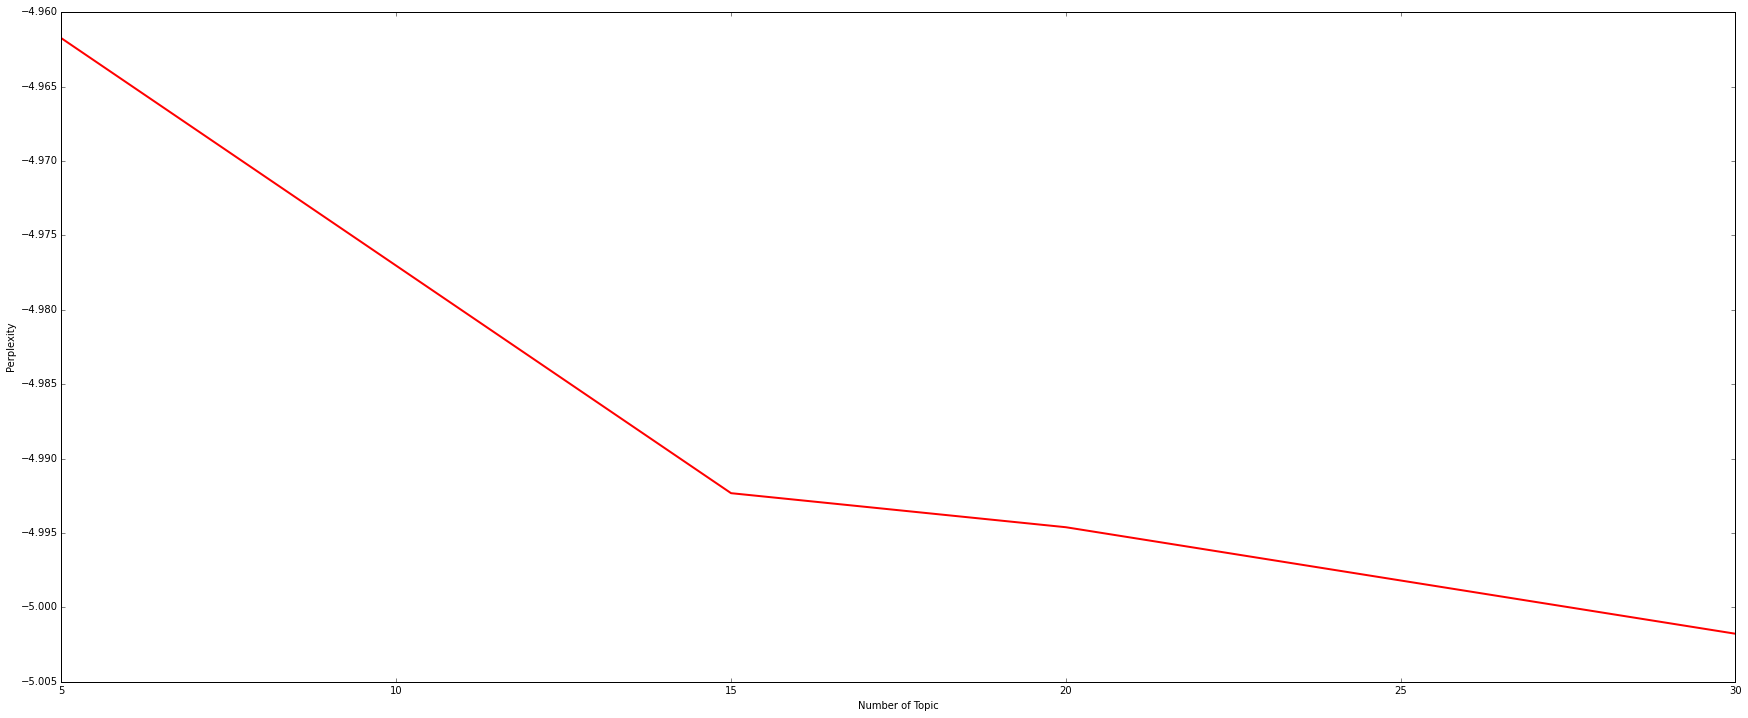

In [609]:
ppnumplot(topicnum, logperplexity)

In [655]:
lda_model = gensim.models.LdaModel(bag_of_words_corpus, num_topics=30, id2word=word_count_dict, passes=10)
_ = lda_model.print_topics(-1) #use _ for throwaway variables.

In [656]:
lda_model.print_topics(5)

[u'0.064*\u516c\u6295 + 0.049*\u6cdb\u6c11 + 0.035*\u771f\u666e\u8054 + 0.030*\u516c\u6c11\u63d0\u540d + 0.021*\u5b66\u6c11\u601d\u6f6e + 0.018*\u5168\u6c11\u6295\u7968 + 0.016*\u53cd\u6c34\u8d27\u5ba2 + 0.015*\u4e94\u533a\u516c\u6295 + 0.013*\u7535\u5b50\u516c\u6295 + 0.012*\u9999\u6e2f',
 u'0.040*kong + 0.039*hong + 0.011*economic + 0.009*city + 0.009*percent + 0.008*world + 0.008*china + 0.007*hk + 0.007*economy + 0.007*plan',
 u'0.020*police + 0.017*vote + 0.011*content + 0.010*emily + 0.009*\u7ebd\u7ea6\u65f6\u62a5 + 0.009*young + 0.008*views + 0.008*\u5168\u6c11\u6295\u7968\u65e5 + 0.008*school + 0.007*director',
 u'0.032*\u636e\u6089 + 0.030*\u636e\u4e86\u89e3 + 0.020*\u53e6\u5916 + 0.016*\u9884\u7ea6\u62d8\u6355 + 0.014*\u6b64\u5916 + 0.012*\u672c\u62a5\u8bb0\u8005 + 0.010*\u4e0d\u8fc7 + 0.008*\u884c\u52a8 + 0.007*\u8868\u793a + 0.007*\u81ea\u9996',
 u'0.017*\u6211\u8981\u771f\u666e\u9009 + 0.014*pdf + 0.013*\u65e5\u81f3 + 0.012*com + 0.010*\u5f53\u65e5 + 0.010*\u4e2a\u4eba\u6e

In [657]:
topictermlist = lda_model.print_topics(-1)
top_words = [[j.split('*')[1] for j in i.split(' + ')] for i in topictermlist] 
top_words_shares = [[j.split('*')[0] for j in i.split(' + ')] for i in topictermlist] 
top_words_shares = [map(float, i) for i in top_words_shares]


In [663]:
top(top_words[0])

一国两制
周年
白皮书
支持特区政府依法施政
他说
全国政协委员
中国梦
年来
全国政协常委
他表示


In [659]:
#https://de.dariah.eu/tatom/topic_model_visualization.html

topictermlist = lda_model.print_topics(-1)
top_words = [[j.split('*')[1] for j in i.split(' + ')] for i in topictermlist] 
top_words_shares = [[j.split('*')[0] for j in i.split(' + ')] for i in topictermlist] 
top_words_shares = [map(float, i) for i in top_words_shares]
def weightvalue(x):
    return (x - np.min(top_words_shares))*40/(np.max(top_words_shares) -np.min(top_words_shares)) + 10
 
top_words_shares = [map(weightvalue, i) for i in top_words_shares]  

def plotTopics(mintopics, maxtopics):
    num_top_words = 10
    plt.rcParams['figure.figsize'] = (30.0, 12.0)  
    n = 0
    for t in range(mintopics , maxtopics):
        plt.subplot(2, 15, n + 1)  # plot numbering starts with 1
        plt.ylim(0, num_top_words)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title('Topic #{}'.format(t))
        words = top_words[t][0:num_top_words ]
        words_shares = top_words_shares[t][0:num_top_words ]
        for i, (word, share) in enumerate(zip(words, words_shares)):
            plt.text(0.05, num_top_words-i-0.9, word, fontsize= share)
        n += 1

In [660]:
np.min(top_words_shares)

10.0

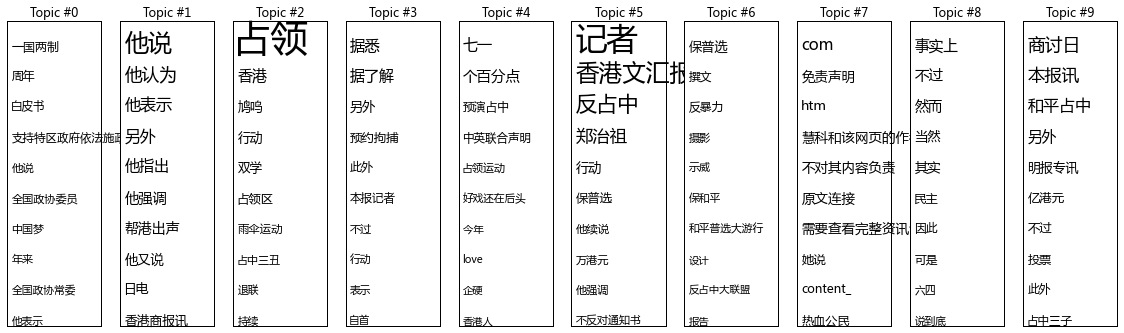

In [667]:
plotTopics(0, 10)

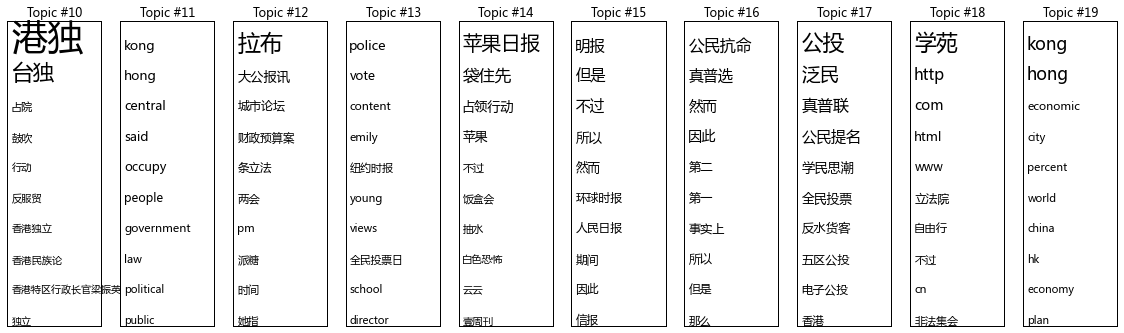

In [668]:
plotTopics(10, 20)

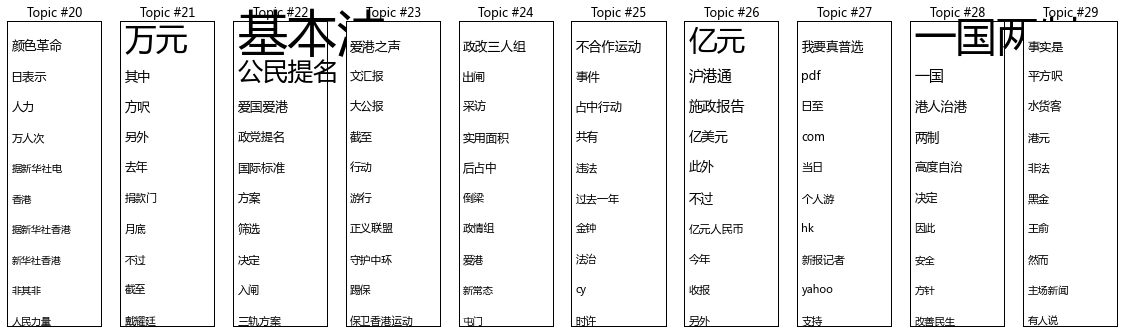

In [669]:
plotTopics(20, 30)

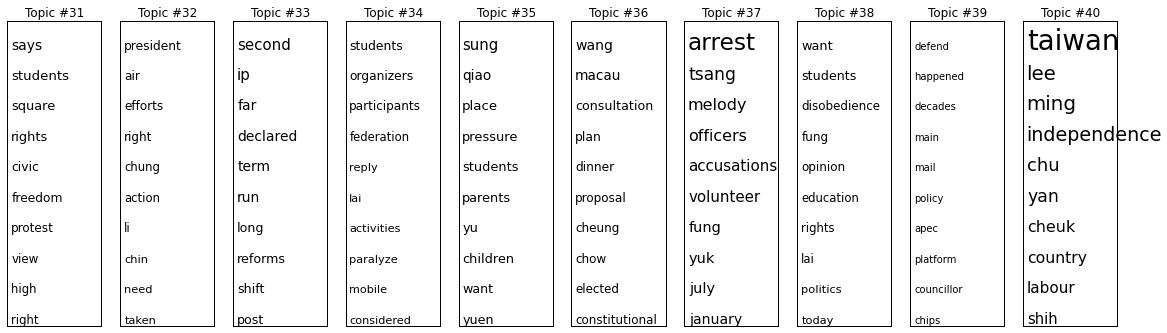

In [543]:
plotTopics(31, 41)

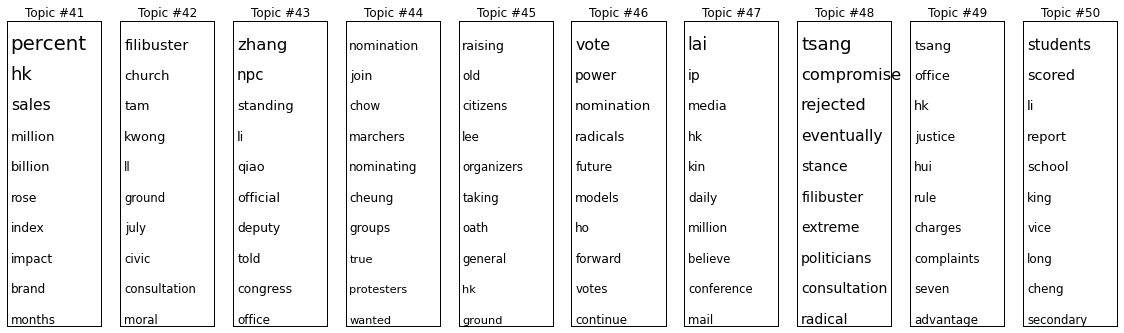

In [544]:
plotTopics(41, 51)

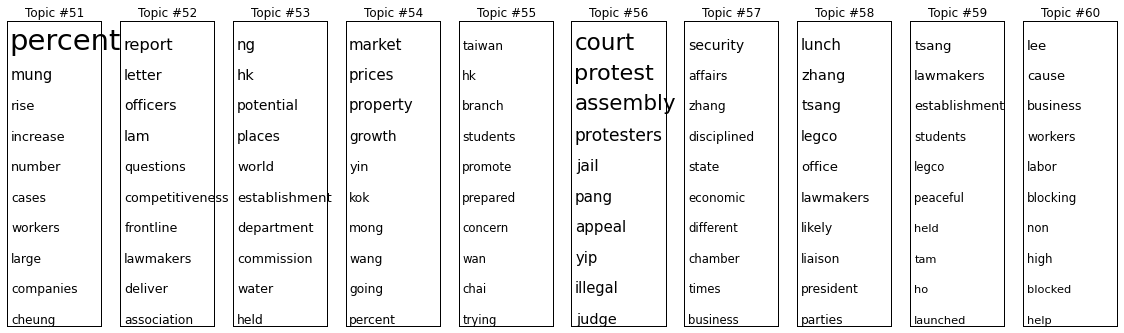

In [586]:
plotTopics(51, 61)


%pylab inline 
from matplotlib.font_manager import fontManager 
import matplotlib.pyplot as plt 
import os 
import os.path 

fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(111) 
plt.subplots_adjust(0, 0, 1, 1, 0, 0) 
plt.xticks([]) 
plt.yticks([]) 
x, y = 0.05, 0.18 
fonts = [font.name for font in fontManager.ttflist if 
    os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
font = set(fonts) 
dy = (1.0-y)/(len(fonts)/4 + (len(fonts)%4!=0)) 
for font in fonts: 
    t = ax.text(x, y, u"中文字体", {'fontname':font, 'fontsize':14}, transform=ax.transAxes) 
    ax.text(x, y-dy/2, font, transform=ax.transAxes) 
    x += 0.25 
    if x >= 1.0: 
        y += dy 
        x = 0.05 
plt.show() 


# 中文字体

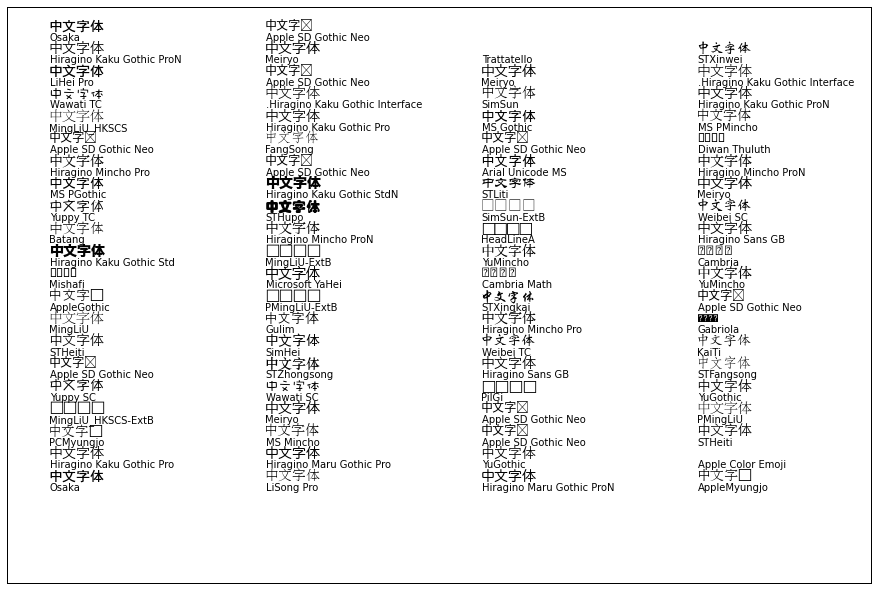

In [618]:
from matplotlib.font_manager import fontManager 
import matplotlib.pyplot as plt 
import os 
import os.path 

fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(111) 
plt.subplots_adjust(0, 0, 1, 1, 0, 0) 
plt.xticks([]) 
plt.yticks([]) 
x, y = 0.05, 0.18 
fonts = [font.name for font in fontManager.ttflist if 
    os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
font = set(fonts) 
dy = (1.0-y)/(len(fonts)/4 + (len(fonts)%4!=0)) 
for font in fonts: 
    t = ax.text(x, y, u"中文字体", {'fontname':font, 'fontsize':14}, transform=ax.transAxes) 
    ax.text(x, y-dy/2, font, transform=ax.transAxes) 
    x += 0.25 
    if x >= 1.0: 
        y += dy 
        x = 0.05 
plt.show() 

#获取百度指数

[占领中环的百度指数](http://index.baidu.com/?tpl=trend&type=0&area=0&time=20130101%7C20150914&word=%D5%BC%C1%EC%D6%D0%BB%B7) inspect数据区域的话显示前两个点大小相同，但是鼠标悬停显示第一个是11，第二个是0。所以，每次鼠标悬停，就触发一次请求。返回的就是精确地数值，而一次inspect，得到的只是粗略的数值。


In [230]:
from IPython.display import HTML
HTML('<iframe src=http://index.baidu.com/?tpl=trend&type=0&area=0&time=20130101%7C20150914&word=%D5%BC%C1%EC%D6%D0%BB%B7 
     width=1000 height=900></iframe>')

In [354]:
d="M20,337.66666666666663L35.3448275862069,213.90572390572387L50.689655172413794,337.66666666666663L66.0344827586207,337.66666666666663L81.37931034482759,337.66666666666663L96.72413793103448,337.66666666666663L112.06896551724138,337.66666666666663L127.41379310344828,337.66666666666663L142.75862068965517,337.66666666666663L158.10344827586206,337.66666666666663L173.44827586206895,337.66666666666663L188.79310344827587,337.66666666666663L204.13793103448276,337.66666666666663L219.48275862068965,337.66666666666663L234.82758620689657,337.66666666666663L250.17241379310346,337.66666666666663L265.51724137931035,216.00336700336698L280.86206896551727,337.66666666666663L296.2068965517241,337.66666666666663L311.55172413793105,337.66666666666663L326.8965517241379,337.66666666666663L342.2413793103448,337.66666666666663L357.58620689655174,337.66666666666663L372.9310344827586,337.66666666666663L388.2758620689655,216.00336700336698L403.62068965517244,337.66666666666663L418.9655172413793,216.00336700336698L434.3103448275862,337.66666666666663L449.65517241379314,337.66666666666663L465,337.66666666666663L480.3448275862069,337.66666666666663L495.6896551724138,337.66666666666663L511.0344827586207,337.66666666666663L526.3793103448277,337.66666666666663L541.7241379310345,216.00336700336698L557.0689655172414,337.66666666666663L572.4137931034483,337.66666666666663L587.7586206896552,213.90572390572387L603.1034482758621,216.00336700336698L618.448275862069,337.66666666666663L633.7931034482758,337.66666666666663L649.1379310344828,337.66666666666663L664.4827586206897,337.66666666666663L679.8275862068965,337.66666666666663L695.1724137931035,337.66666666666663L710.5172413793103,337.66666666666663L725.8620689655172,337.66666666666663L741.2068965517242,337.66666666666663L756.551724137931,216.00336700336698L771.8965517241379,216.00336700336698L787.2413793103449,337.66666666666663L802.5862068965517,134.19528619528617L817.9310344827586,169.85521885521882L833.2758620689656,337.66666666666663L848.6206896551724,205.51515151515147L863.9655172413793,216.00336700336698L879.3103448275863,213.90572390572387L894.6551724137931,337.66666666666663L910,134.19528619528617"

In [355]:
def getBaiduIndex(d):
    dl = d.split(',')[1:-1]
    dlist = [i.split('L') for i in dl]
    dlist = np.array(dlist).T
    x = dlist[1]
    y = [float(max(dlist[0]))- float(i) for i in dlist[0]]
    return x, y

In [357]:
y

[0.0,
 123.76094276094275,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 121.66329966329965,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 121.66329966329965,
 0.0,
 121.66329966329965,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 121.66329966329965,
 0.0,
 0.0,
 123.76094276094275,
 121.66329966329965,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 121.66329966329965,
 121.66329966329965,
 0.0,
 203.47138047138046,
 167.8114478114478,
 0.0,
 132.15151515151516,
 121.66329966329965,
 123.76094276094275,
 0.0]

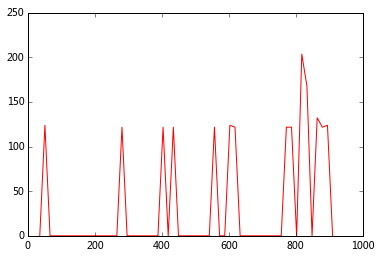

In [356]:
x, y = getBaiduIndex(d)
plt.plot(x, y,marker='',linestyle='-',color='r',label=str(month))

In [296]:
import pandas as pd
week = pd.date_range('2012-12-30', periods=118, freq='W')

In [334]:
from datetime import *

month_data=defaultdict(list)
for i in range(116):
    dates = str(week[i])[:7]+'-01'
    dates = date(int(dates[:4]), int(dates[5:7]), int(dates[8:10]))
    month_data[dates].append(y[i])
    

In [341]:
query = [(i, np.sum(month_data[i])) for i in sorted(month_data)][1:]

In [348]:
month, baiduindex = np.array(query).T

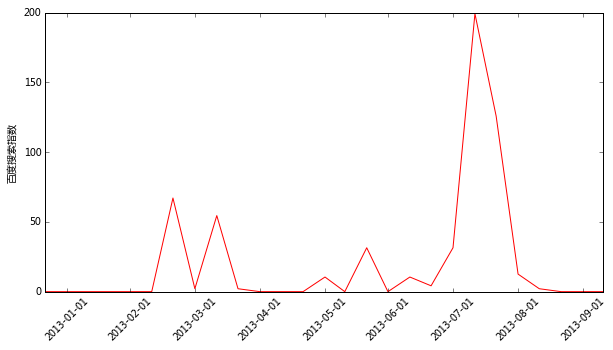

In [353]:
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(111)
ax.plot(month, baiduindex,marker='',linestyle='-',color='r',label=str(month))
ax.set_xticklabels(month, rotation= 45)
plt.ylabel(u'百度搜索指数')
#plt.yscale('log')
plt.show()

In [209]:
65974 / float(max(dlist[0]))

195.38203356367228

In [212]:
d.split(',')[0]

'M20'

In [213]:
d.split(',')[-1]

'337.66666666666663'

In [214]:
float(max(dlist[0]))

337.66666666666663

In [225]:
float(min(dlist[0]))
# 65974

142.58585858585855

In [224]:
max(y), min(y)

(195.08080808080808, 0.0)

In [231]:
141*7

987